# Clustering Analysis on TREC-COVID Dataset (Round 1)
This notebook performs document clustering and cluster interpretation on the TREC-COVID dataset using the CORD-19 corpus. It includes clustering, evaluation, interpretation, and visualization steps.


## Setup & Imports


In [2]:
import sys
import os

# Add the parent folder of 'src' to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(""), '..', 'src')))

%pip install ir_datasets numpy matplotlib seaborn scikit-learn scipy wordcloud

import ir_datasets
import numpy as np
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from clusters import clustering, interpret, evaluate, compute_global_centroid, compute_global_centroid_represent_cluster, run_clustering_experiments
from plots import plot_cluster_divergence, plot_top_divergent_terms, plot_cluster_kl_divergence, plot_tsne, plot_wordcloud, plot_results
from preprocessing import preprocess_text

# Download necessary NLTK resources
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download('universal_tagset')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading pa

True

## Load and Preprocess Dataset


In [3]:
dataset = ir_datasets.load("cord19/trec-covid/round1")
all_docs = [(doc.doc_id, f"{doc.title or ''} {doc.abstract or ''}") for doc in dataset.docs_iter() if doc.abstract]
all_doc_ids, all_texts = zip(*all_docs)

## Run Clustering with Fixed k=25 (Best Value)

In [4]:
# Run clustering and reuse vectorizer
clusters, vectorizer, X = clustering(dataset.docs_iter())

# Recompute global centroid using the same vectorizer
global_centroid = compute_global_centroid_represent_cluster(dataset.docs_iter(), vectorizer)

c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 25, silhouette score: 0.0147


## Visualize t-SNE Embedding of Clusters


In [ ]:
# Build doc_id → cluster label mapping
flat_cluster_dict = dict(zip(all_doc_ids, clusters))

# Filter X and labels
filtered_indices = [i for i, doc_id in enumerate(all_doc_ids) if doc_id in flat_cluster_dict]
X_filtered = X[filtered_indices]
labels_filtered = [flat_cluster_dict[all_doc_ids[i]] for i in filtered_indices]


# Plot
plot_tsne(X_filtered, labels_filtered)

[22, 23]


## Cluster Interpretation: KL Divergence & Top Terms


In [5]:
cluster_labels = []
kl_divergences = []
label_summaries = []
cluster_divergent_terms = []

# Interpret each cluster
for cluster in clusters:
    interpretation = interpret(
        cluster,
        dataset.docs_iter(),
        global_centroid=global_centroid,
        global_vectorizer=vectorizer
    )

    print(f"\nCluster {cluster[0]}:")
    print(f"  Medoid Doc ID: {interpretation['medoid']}")
    print(f"  Top Terms (TF-IDF): {', '.join(interpretation['top_terms'])}")
    print("  Divergent Terms (KL Contribution):")
    for term, score in zip(interpretation['divergent_terms'], interpretation['divergent_scores']):
        print(f"    - {term}: {score:.4e}")
    print(f"  Total KL Divergence: {interpretation['kl_divergence']:.4f}")

    cluster_labels.append(f"Cluster {cluster[0]}")
    kl_divergences.append(interpretation['kl_divergence'])
    label_summaries.append(" / ".join(interpretation['divergent_terms'][:3]))
    cluster_divergent_terms.append(set(interpretation['divergent_terms']))


Cluster 21:
  Medoid Doc ID: a8yfi2wn
  Top Terms (TF-IDF): detection, assay, sample, virus, pcr, test, amplification, sensitivity, method, use
  Divergent Terms (KL Contribution):
    - detection: 3.8168e-02
    - assay: 3.5961e-02
    - pcr: 2.0057e-02
    - amplification: 1.8101e-02
    - sample: 1.7694e-02
    - sensitivity: 1.4975e-02
    - realtime: 1.3575e-02
    - rtpcr: 1.1727e-02
    - test: 1.0924e-02
    - multiplex: 1.0882e-02
  Total KL Divergence: 0.9084

Cluster 12:
  Medoid Doc ID: tuhesrpb
  Top Terms (TF-IDF): virus, use, study, infection, disease, gene, sequence, human, analysis, result
  Divergent Terms (KL Contribution):
    - dog: 1.2599e-03
    - rat: 1.2091e-03
    - air: 8.1048e-04
    - canine: 6.2347e-04
    - chapter: 5.7000e-04
    - pig: 5.5819e-04
    - tourism: 5.2288e-04
    - application: 5.0260e-04
    - disaster: 4.9354e-04
    - los: 4.8881e-04
  Total KL Divergence: 0.1652

Cluster 10:
  Medoid Doc ID: axgqvbkj
  Top Terms (TF-IDF): sars, sarscov

## KL Divergence Bar Chart


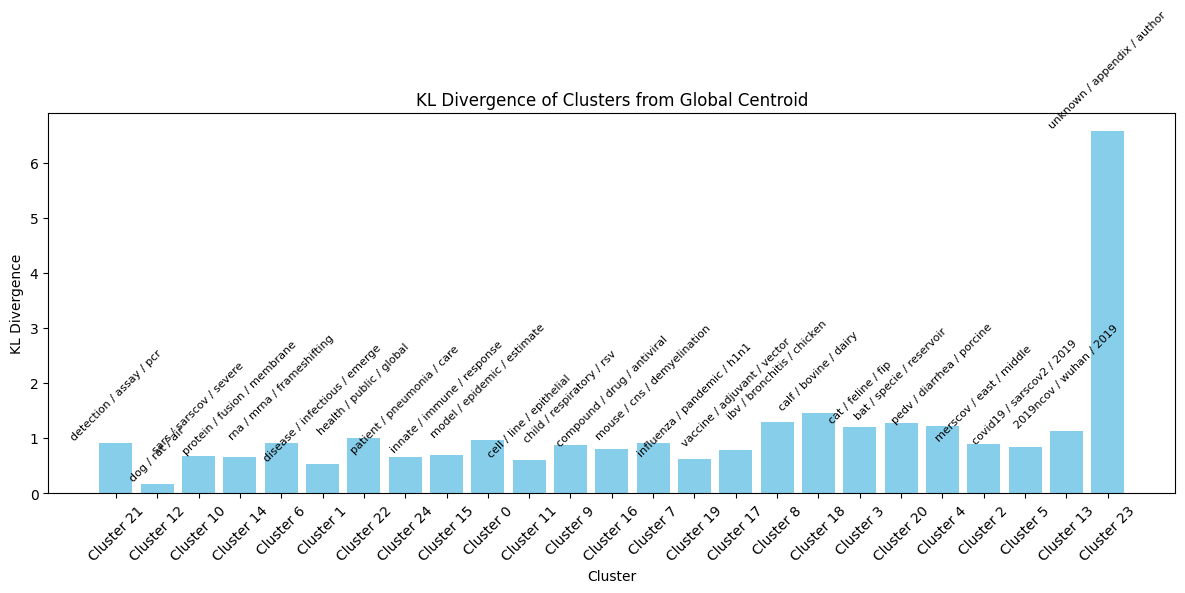

In [6]:
plot_cluster_divergence(cluster_labels, kl_divergences, label_summaries)


## Analyze Divergent Terms Across Clusters



=== Most Common Divergent Terms Across Clusters ===
respiratory: 3 clusters
patient: 3 clusters
pig: 2 clusters
outbreak: 2 clusters
syndrome: 2 clusters
sarscov: 2 clusters
structure: 2 clusters
replication: 2 clusters
surveillance: 2 clusters
infectious: 2 clusters
zoonotic: 2 clusters
care: 2 clusters
pneumonia: 2 clusters
response: 2 clusters
immune: 2 clusters


C:\Users\franc\AppData\Local\Temp\ipykernel_18788\2648233743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette="viridis")


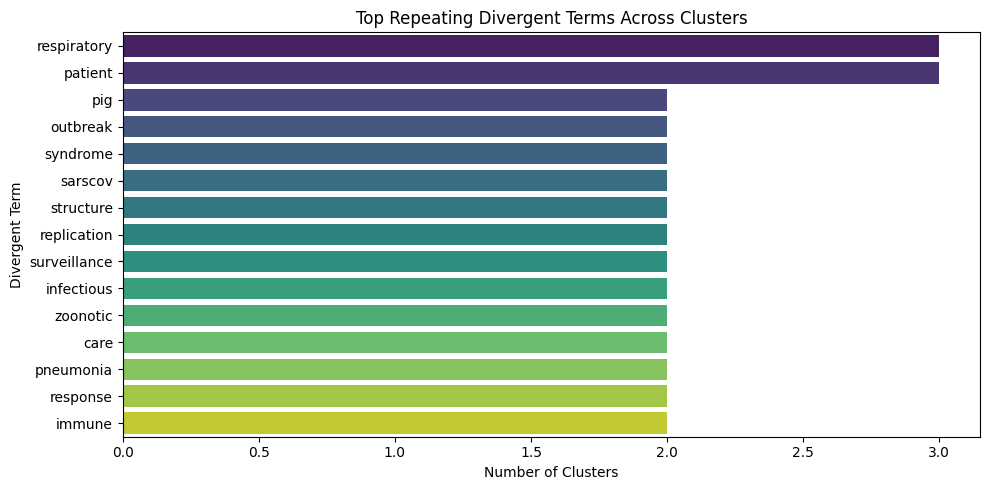

In [6]:
# Flatten all divergent terms into one list
all_divergent_terms = [term for cluster in cluster_divergent_terms for term in cluster]

# Count how often each divergent term appears across clusters
from collections import Counter
term_freq = Counter(all_divergent_terms)

# Show most repeated divergent terms
most_common_terms = term_freq.most_common(15)
print("\n=== Most Common Divergent Terms Across Clusters ===")
for term, count in most_common_terms:
    print(f"{term}: {count} clusters")

# Plot bar chart of most repeated divergent terms
terms, counts = zip(*most_common_terms)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(terms), palette="viridis")
plt.xlabel("Number of Clusters")
plt.ylabel("Divergent Term")
plt.title("Top Repeating Divergent Terms Across Clusters")
plt.tight_layout()
plt.show()

## Co-occurrence Network and Similarity of Divergent Terms


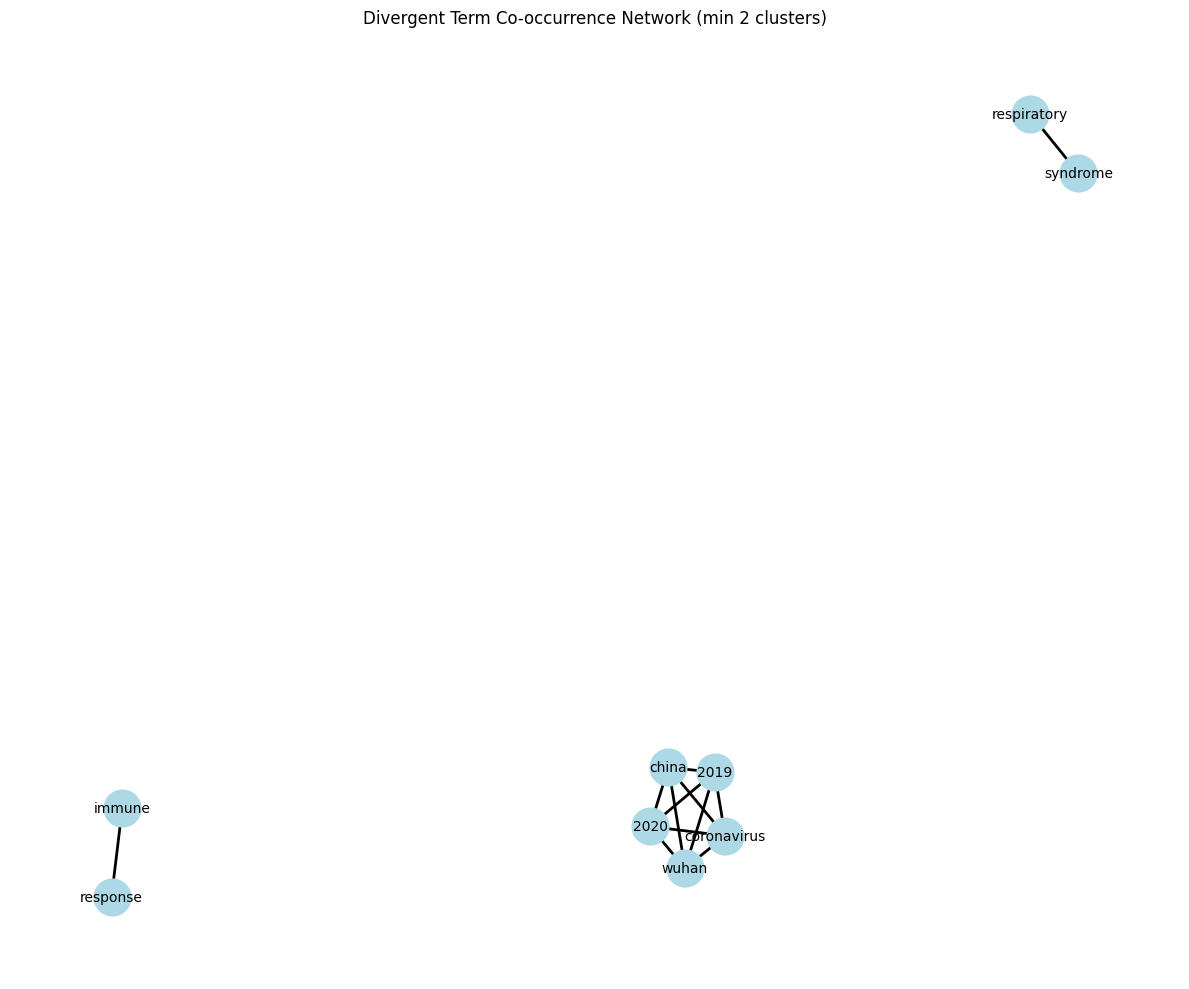

In [7]:
# Build co-occurrence graph
G = nx.Graph()
for terms in cluster_divergent_terms:
    terms = list(terms)
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            t1, t2 = terms[i], terms[j]
            if G.has_edge(t1, t2):
                G[t1][t2]['weight'] += 1
            else:
                G.add_edge(t1, t2, weight=1)

# Filter weak edges
min_weight = 2
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_weight]
G.remove_edges_from(edges_to_remove)
G.remove_nodes_from(list(nx.isolates(G)))

# Plot network
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=weights)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Divergent Term Co-occurrence Network (min 2 clusters)")
plt.axis("off")
plt.tight_layout()
plt.show()

## Repeated Terms and Jaccard Similarity Matrix



=== Repeating Divergent Terms Across Clusters ===
'pig' appears in clusters: [1, 20]
'outbreak' appears in clusters: [2, 9]
'respiratory' appears in clusters: [2, 11, 21]
'syndrome' appears in clusters: [2, 21]
'sarscov' appears in clusters: [2, 3]
'patient' appears in clusters: [2, 7, 22]
'structure' appears in clusters: [3, 4]
'replication' appears in clusters: [4, 8]
'surveillance' appears in clusters: [5, 6]
'infectious' appears in clusters: [5, 16]
'zoonotic' appears in clusters: [5, 19]
'care' appears in clusters: [6, 7]
'pneumonia' appears in clusters: [7, 23]
'response' appears in clusters: [8, 15]
'immune' appears in clusters: [8, 15]
'epidemic' appears in clusters: [9, 20]
'cell' appears in clusters: [10, 13]
'avian' appears in clusters: [14, 16]
'strain' appears in clusters: [16, 20]
'diarrhea' appears in clusters: [17, 20]
'2019' appears in clusters: [22, 23]
'china' appears in clusters: [22, 23]
'coronavirus' appears in clusters: [22, 23]
'wuhan' appears in clusters: [22,

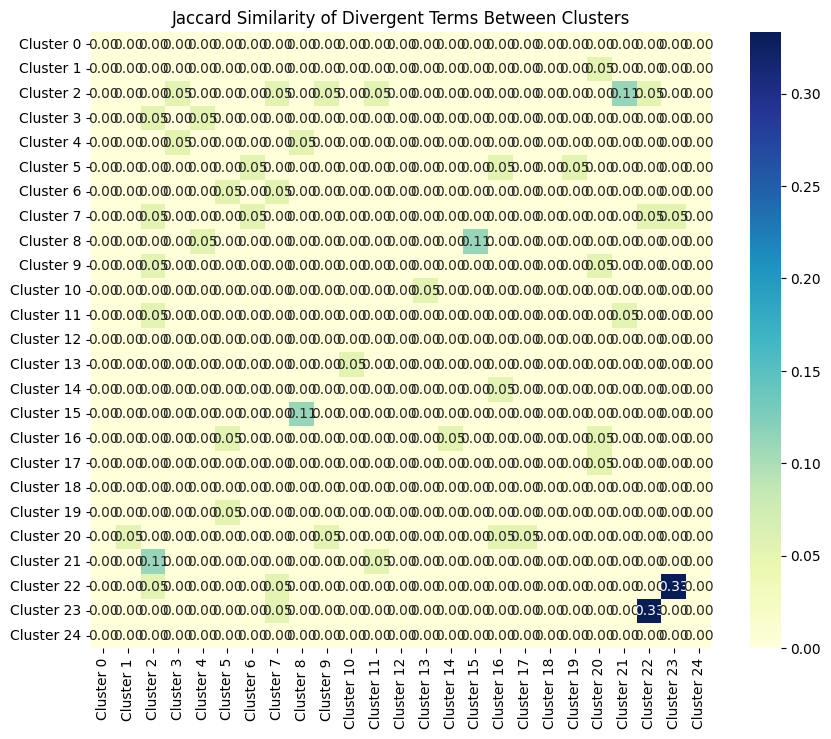

In [8]:
term_to_clusters = defaultdict(list)
for i, terms in enumerate(cluster_divergent_terms):
    for term in terms:
        term_to_clusters[term].append(i)

repeated_terms = {term: clusters for term, clusters in term_to_clusters.items() if len(clusters) > 1}

print("\n=== Repeating Divergent Terms Across Clusters ===")
for term, clusters in repeated_terms.items():
    print(f"'{term}' appears in clusters: {clusters}")

# Jaccard similarity matrix
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(cluster_divergent_terms)
n_clusters = len(cluster_divergent_terms)
jaccard_sim_matrix = np.zeros((n_clusters, n_clusters))

for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:
            jaccard_sim_matrix[i, j] = jaccard_score(binary_matrix[i], binary_matrix[j])

plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_sim_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
            yticklabels=[f"Cluster {i}" for i in range(n_clusters)])
plt.title("Jaccard Similarity of Divergent Terms Between Clusters")
plt.show()

## Term-Cluster Matrix


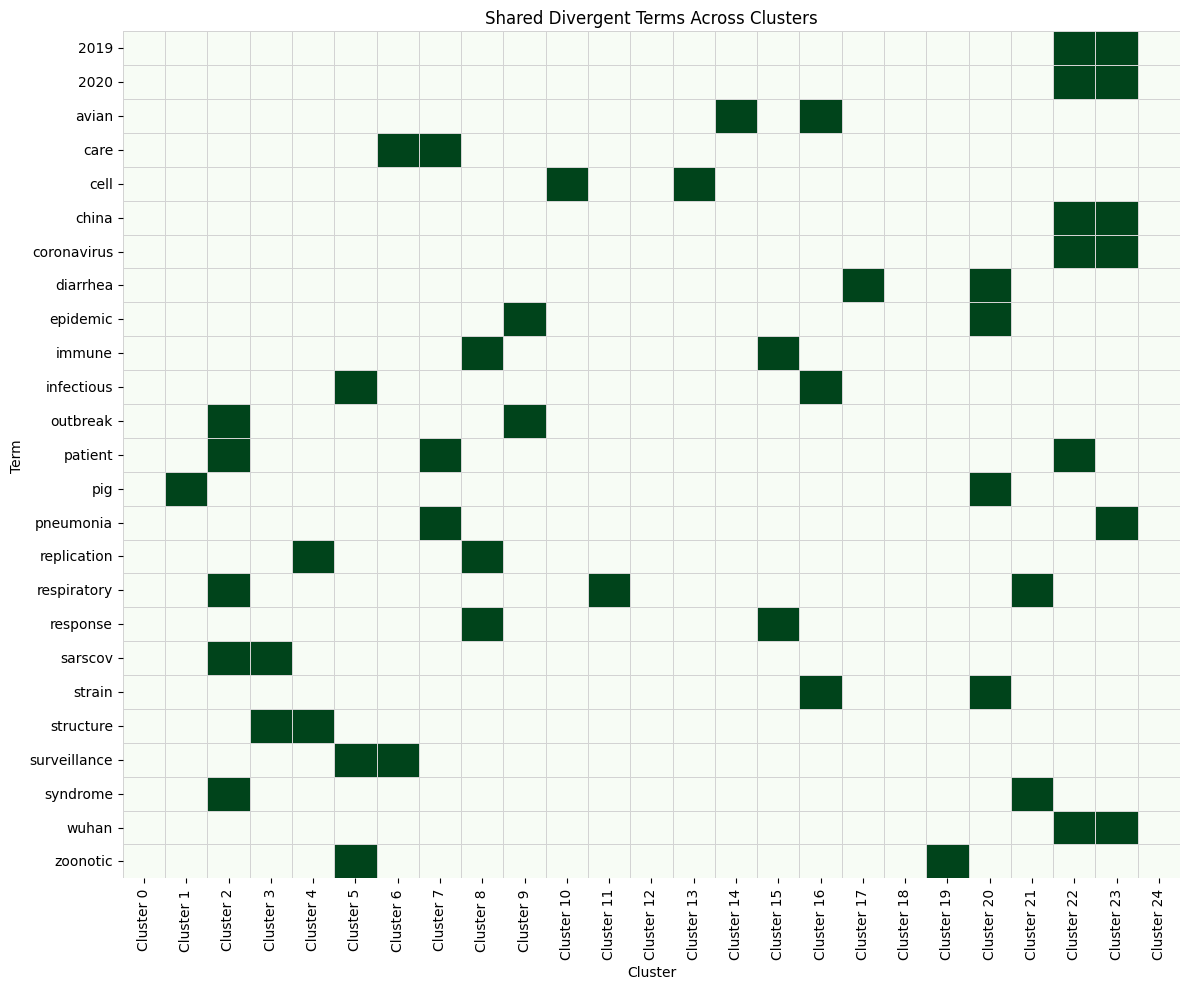

In [ ]:
# Term-cluster matrix for shared terms
terms = sorted(repeated_terms.keys())
term_cluster_matrix = np.zeros((len(terms), n_clusters))
for i, term in enumerate(terms):
    for cluster_idx in repeated_terms[term]:
        term_cluster_matrix[i][cluster_idx] = 1

plt.figure(figsize=(12, len(terms) * 0.4))
sns.heatmap(term_cluster_matrix, cmap="Greens", cbar=False,
            xticklabels=[f"Cluster {i}" for i in rsange(n_clusters)],
            yticklabels=terms, linewidths=0.5, linecolor='lightgray')
plt.title("Shared Divergent Terms Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

## Run Experiments for Different k Values (for Comparison)


In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    stop_words='english',
    tokenizer=preprocess_text,
    preprocessor=None
)
X = vectorizer.fit_transform(all_texts)

# Compare methods and ks
run_clustering_experiments(X, all_doc_ids, method_list=["kmeans", "agglomerative"], k_values=[5, 10, 15, 20, 25])

c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(



=== KMEANS Clustering ===


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k =  5 | Silhouette: 0.0041 | Calinski-Harabasz: 175.93 | Davies-Bouldin: 10.4506


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 10 | Silhouette: 0.0070 | Calinski-Harabasz: 137.52 | Davies-Bouldin: 8.9299


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 15 | Silhouette: 0.0118 | Calinski-Harabasz: 124.71 | Davies-Bouldin: 7.1836


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 20 | Silhouette: 0.0133 | Calinski-Harabasz: 112.92 | Davies-Bouldin: 7.2953


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 25 | Silhouette: 0.0147 | Calinski-Harabasz: 102.27 | Davies-Bouldin: 6.9589

=== AGGLOMERATIVE Clustering ===


## Cluster Label Map

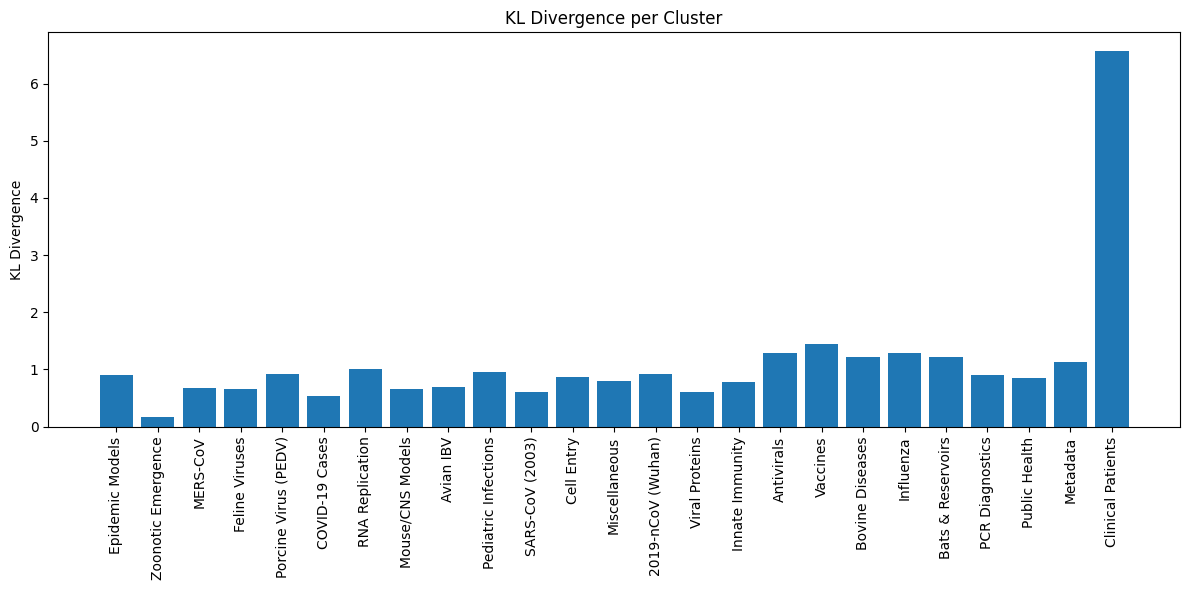

In [24]:
cluster_label_map = {
    0: "Epidemic Models",
    1: "Zoonotic Emergence",
    2: "MERS-CoV",
    3: "Feline Viruses",
    4: "Porcine Virus (PEDV)",
    5: "COVID-19 Cases",
    6: "RNA Replication",
    7: "Mouse/CNS Models",
    8: "Avian IBV",
    9: "Pediatric Infections",
    10: "SARS-CoV (2003)",
    11: "Cell Entry",
    12: "Miscellaneous",
    13: "2019-nCoV (Wuhan)",
    14: "Viral Proteins",
    15: "Innate Immunity",
    16: "Antivirals",
    17: "Vaccines",
    18: "Bovine Diseases",
    19: "Influenza",
    20: "Bats & Reservoirs",
    21: "PCR Diagnostics",
    22: "Public Health",
    23: "Metadata",
    24: "Clinical Patients"
}

# Basic bar plot of cluster KL divergences
plt.figure(figsize=(12, 6))
plt.bar(range(len(cluster_label_map)), kl_divergences)
plt.xticks(range(len(cluster_label_map)), [cluster_label_map[i] for i in range(len(cluster_label_map))], rotation=90)
plt.ylabel("KL Divergence")
plt.title("KL Divergence per Cluster")
plt.tight_layout()
plt.show()

# Additional Plots

c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


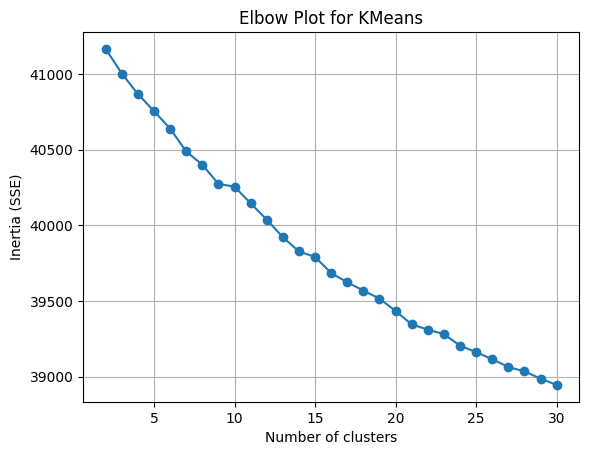

In [9]:
inertias = []
for k in range(2, 31):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(km.inertia_)

plt.plot(range(2, 31), inertias, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.grid(True)
plt.show()


## Cluster top TF-IDF terms

C:\Users\franc\AppData\Local\Temp\ipykernel_18788\3511968347.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(repeated_terms.keys()), y=list(repeated_terms.values()), palette="viridis")


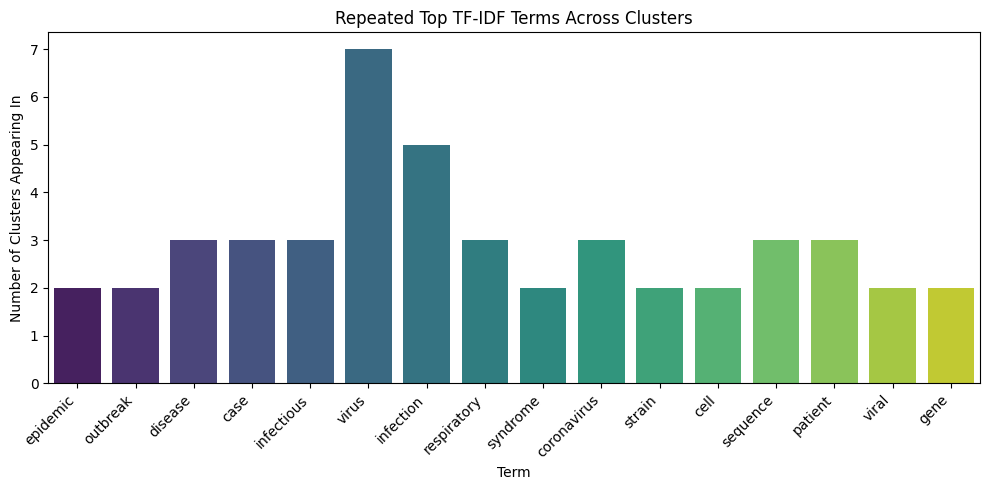

In [ ]:
# Cluster top TF-IDF terms
cluster_top_terms = {
    0: ["model", "epidemic", "transmission", "estimate", "outbreak", "disease", "case", "network", "data", "number"],
    1: ["disease", "infectious", "pathogen", "emerge", "virus", "human", "animal", "infection", "health", "new"],
    2: ["merscov", "east", "middle", "respiratory", "syndrome", "coronavirus", "camel", "mers", "case", "infection"],
    3: ["cat", "feline", "fip", "fcov", "peritonitis", "fipv", "fiv", "virus", "infectious", "infection"],
    4: ["pedv", "porcine", "diarrhea", "epidemic", "strain", "piglet", "virus", "pig", "cell", "sequence"],
    5: ["covid19", "patient", "case", "sarscov2", "2019", "china", "coronavirus", "2020", "wuhan", "disease"],
    6: ["rna", "virus", "sequence", "genome", "mrna", "replication", "viral", "protein", "structure", "gene"],
    7: ["mouse", "cell", "cns", "virus", "infection", "demyelination", "hepatitis", "mhv", "brain", "response"],
    8: ["ibv", "bronchitis", "strain", "chicken", "infectious", "virus", "avian", "gene", "sequence", "vaccine"],
    9: ["respiratory", "child", "infection", "virus", "rsv", "viral", "tract", "patient", "rhinovirus", "asthma"],
    10: ["sars", "sarscov", "severe", "acute", "syndrome", "respiratory", "patient", "coronavirus", "outbreak", "2003"],
}

# Flatten and count term occurrences across clusters
all_terms = [term for terms in cluster_top_terms.values() for term in terms]
term_counts = Counter(all_terms)

# Select terms that appear in more than one cluster
repeated_terms = {term: count for term, count in term_counts.items() if count > 1}

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(repeated_terms.keys()), y=list(repeated_terms.values()), palette="viridis")
plt.title("Repeated Top TF-IDF Terms Across Clusters")
plt.ylabel("Number of Clusters Appearing In")
plt.xlabel("Term")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Top 10 KL-divergent terms


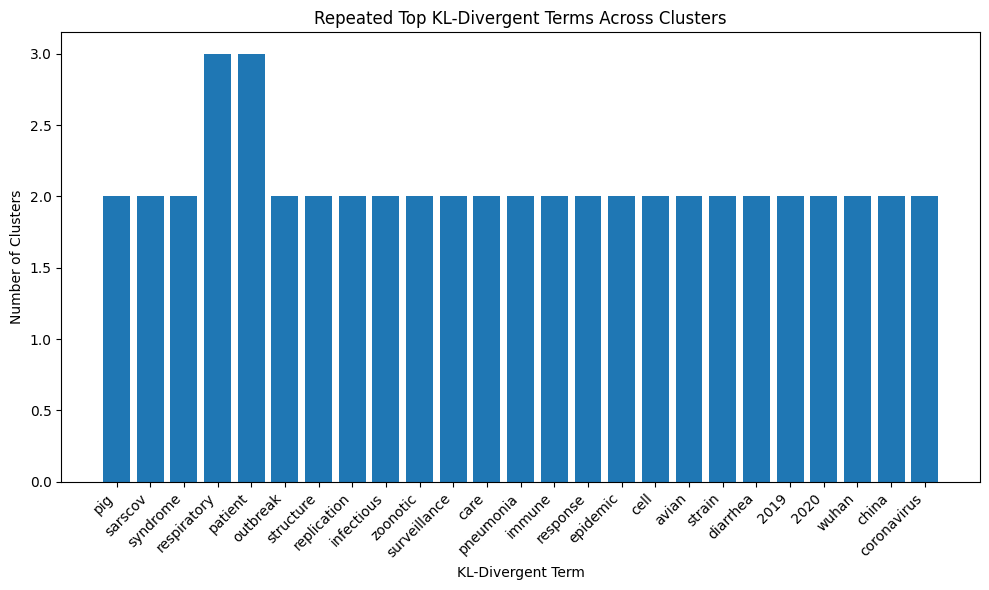

In [ ]:
top_kl_terms_per_cluster = [
    ['detection', 'assay', 'pcr', 'amplification', 'sample', 'sensitivity', 'realtime', 'rtpcr', 'test', 'multiplex'],
    ['dog', 'rat', 'air', 'canine', 'chapter', 'pig', 'tourism', 'application', 'disaster', 'los'],
    ['sars', 'sarscov', 'severe', 'syndrome', 'acute', '2003', 'respiratory', 'patient', 'outbreak', 'hong'],
    ['protein', 'fusion', 'membrane', 'domain', 'glycoprotein', 'sarscov', 'peptide', 'spike', 'structure', 'amino'],
    ['rna', 'mrna', 'frameshifting', 'genome', 'sequence', 'replication', 'synthesis', 'subgenomic', 'translation', 'structure'],
    ['disease', 'infectious', 'emerge', 'pathogen', 'animal', 'zoonotic', 'emergence', 'wildlife', 'human', 'surveillance'],
    ['health', 'public', 'global', 'emergency', 'international', 'care', 'policy', 'preparedness', 'security', 'surveillance'],
    ['patient', 'pneumonia', 'care', 'hospital', 'exacerbation', 'icu', 'treatment', 'antibiotic', 'cap', 'communityacquired'],
    ['innate', 'immune', 'response', 'host', 'ifn', 'autophagy', 'pathway', 'interferon', 'signal', 'replication'],
    ['model', 'epidemic', 'estimate', 'transmission', 'network', 'dynamic', 'contact', 'outbreak', 'number', 'reproduction'],
    ['cell', 'line', 'epithelial', 'entry', 'receptor', 'apoptosis', 'cd8', 'expression', 'culture', 'cd4'],
    ['child', 'respiratory', 'rsv', 'tract', 'rhinovirus', 'asthma', 'hmpv', 'infection', 'syncytial', 'hbov'],
    ['compound', 'drug', 'antiviral', 'activity', 'inhibitor', 'protease', 'derivative', 'target', '3clpro', 'ic50'],
    ['mouse', 'cns', 'demyelination', 'brain', 'hepatitis', 'mhv', 'nervous', 'cell', 'murine', 'central'],
    ['influenza', 'pandemic', 'h1n1', 'h5n1', '2009', 'avian', 'virus', 'seasonal', 'ah1n1pdm09', 'ili'],
    ['vaccine', 'adjuvant', 'vector', 'vaccination', 'dna', 'immunogenicity', 'response', 'immunization', 'immune', 'mucosal'],
    ['ibv', 'bronchitis', 'chicken', 'strain', 'infectious', 'avian', 'ibvs', 'flock', 'broiler', 'recombination'],
    ['calf', 'bovine', 'dairy', 'diarrhea', 'colostrum', 'rotavirus', 'cryptosporidium', 'cow', 'herd', 'calve'],
    ['cat', 'feline', 'fip', 'fcov', 'peritonitis', 'fipv', 'fiv', 'felv', 'fecv', 'domestic'],
    ['bat', 'specie', 'reservoir', 'fruit', 'coronaviruses', 'covs', 'myotis', 'zoonotic', 'diversity', 'mammal'],
    ['pedv', 'diarrhea', 'porcine', 'epidemic', 'piglet', 'pig', 'strain', 'ped', 'swine', 'orf3'],
    ['merscov', 'east', 'middle', 'camel', 'mers', 'syndrome', 'saudi', 'arabia', 'dromedary', 'respiratory'],
    ['covid19', 'sarscov2', '2019', '2020', 'case', 'wuhan', 'patient', 'china', 'february', 'coronavirus'],
    ['2019ncov', 'wuhan', '2019', 'china', 'coronavirus', 'novel', '2020', 'hubei', 'pneumonia', 'december'],
    ['unknown', 'appendix', 'author', 'index', 'subject', 'copyright', 'list', 'overview', 'introduction', 'classification']
]

kl_term_counts = Counter(term for cluster in top_kl_terms_per_cluster for term in cluster)
repeated_kl_terms = {term: count for term, count in kl_term_counts.items() if count > 1}

plt.figure(figsize=(10, 6))
plt.bar(repeated_kl_terms.keys(), repeated_kl_terms.values())
plt.xticks(rotation=45, ha='right')
plt.title("Repeated Top KL-Divergent Terms Across Clusters")
plt.ylabel("Number of Clusters")
plt.xlabel("KL-Divergent Term")
plt.tight_layout()
plt.show()
